# CNN AE について解説
- https://atmarkit.itmedia.co.jp/ait/articles/2007/10/news024_2.html

In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10  # CIFAR10もインポートしておく
import numpy as np
import matplotlib.pyplot as plt

class Encoder(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 512)
        self.fc2 = torch.nn.Linear(512, 64)
        self.fc3 = torch.nn.Linear(64, 16)
        self.fc4 = torch.nn.Linear(16, 2)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 16)
        self.fc2 = torch.nn.Linear(16, 64)
        self.fc3 = torch.nn.Linear(64, 512)
        self.fc4 = torch.nn.Linear(512, output_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))  # -1～1に変換
        return x

class AutoEncoder(torch.nn.Module):
    def __init__(self, org_size):
        super().__init__()
        self.enc = Encoder(org_size)
        self.dec = Decoder(org_size)
    def forward(self, x):
        x = self.enc(x)  # エンコード
        x = self.dec(x)  # デコード
        return x

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = MNIST('./data_tutorial_VAE_02', train=True, transform=transform, download=True)
testset = MNIST('./data_tutorial_VAE_02', train=False, transform=transform, download=True)

batch_size = 50
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data_tutorial_VAE_02/MNIST/raw/train-images-idx3-ubyte.gz to ./data_tutorial_VAE_02/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data_tutorial_VAE_02/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_tutorial_VAE_02/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data_tutorial_VAE_02/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_tutorial_VAE_02/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data_tutorial_VAE_02/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_tutorial_VAE_02/MNIST/raw



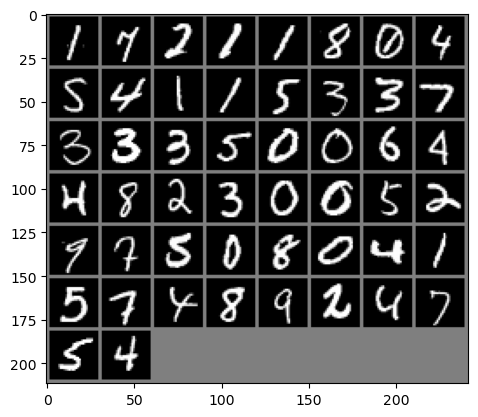

In [3]:
def imshow(img):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

iterator = iter(trainloader)
x, _ = next(iterator)
imshow(x)

In [4]:
def select_device():
    # “”"GPU もしくは CPU の選択“”"
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is selected as device!')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print('mps is selected as device!')
    else:
        device = torch.device('cpu')
        print('cpu....f')
    return device

device = select_device()

mps is selected as device!


In [10]:
def train(net, criterion, optimizer, epochs, trainloader):
    losses = []
    output_and_label = []

    for epoch in range(1, epochs+1):
        print(f'epoch: {epoch}, ', end='')
        running_loss = 0.0
        for counter, (img, _) in enumerate(trainloader, 1):
            optimizer.zero_grad()
            img = img.reshape(-1, input_size)
            output = net(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / counter
        losses.append(avg_loss)
        print('loss:', avg_loss)
        output_and_label.append((output, img))
    print('finished')
    return output_and_label, losses

input_size = 28 * 28
net = AutoEncoder(input_size)
net.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
EPOCHS = 100

output_and_label, losses = train(net, criterion, optimizer, EPOCHS, trainloader)

epoch: 1, 

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
output, org = output_and_label[-1]
imshow(org.reshape(-1, 1, 28, 28))
imshow(output.reshape(-1, 1, 28, 28))